# Kickstarter: Classification
Tests Include:
-KNN
-Logistic Regression
-Decision Trees
-Random Forest
-SVM
-Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import sqlalchemy
from sqlalchemy import create_engine
from flask_sqlalchemy import SQLAlchemy

from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import label_binarize, scale, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder

import datetime
import warnings
import os

warnings.filterwarnings("ignore") #, category=DeprecationWarning)

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

# the values of those depend on your setup
POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
df = pd.read_pickle('data/kickstarter_data_ds2.pkl')
df['idx'] = df['id']
df = df.set_index('idx')
# df = pd.read_sql_query('''SELECT * FROM kickstarter_data_ds2''',engine)
df['state'] = df['state'].replace({'failed': 0, 'successful': 1})
print(df.shape)
# pd.read_sql_query('''SELECT state, main_category, main_category, currency, currency, deadline, launched, usd_goal_real, usd_pledged_real FROM kickstarter_data_ds2 LIMIT 5''',engine)
df.head()

(163425, 18)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,deadline,launched,created,staff_pick,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,
1396766240,1396766240,Ripple Playing Cards - Printed by USPCC,0,games,Playing Cards,131,0.3,3387.000000,9999.000000,US,USD,38,2018-01-12,2017-12-05,2017-10-08,0,B.Y. Eidelman,16
2065169465,2065169465,Cotton-Top Pastries,1,food,Small Batch,99,1.3,9858.000000,7500.000000,US,USD,30,2018-01-12,2017-12-13,2017-12-12,1,Holly Weist,5
1647325451,1647325451,Code Switch,1,film_and_video,Horror,34,1.5,4611.000000,3000.000000,US,USD,32,2018-01-12,2017-12-11,2017-11-10,0,Alba Roland,23
727157486,727157486,Rain Dog Farm,0,food,Farms,49,0.3,4741.000000,18000.000000,US,USD,38,2018-01-12,2017-12-05,2017-11-28,1,Charlie Wainger,9
1756145145,1756145145,WANGTA: a novel,1,publishing,Fiction,13,1.0,427.185132,427.185132,CA,CAD,21,2018-01-12,2017-12-22,2017-12-18,0,D. H. de Bruin,22


In [6]:
df.corr().sort_values('state')

,id,state,backers_count,pct_goal_achieved,usd_pledged,usd_goal,campaign_length,staff_pick,blurb_length
campaign_length,0.005133,-0.089709,0.005262,-0.005714,0.015575,0.024598,1.000000,-0.009770,0.037894
usd_goal,0.003757,-0.033841,0.014228,-0.000685,0.016147,1.000000,0.024598,-0.005367,-0.002520
id,1.000000,-0.003156,-0.001980,-0.001269,-0.000468,0.003757,0.005133,0.001558,0.000146
blurb_length,0.000146,0.001104,-0.013996,-0.002498,-0.012055,-0.002520,0.037894,-0.021259,1.000000
pct_goal_achieved,-0.001269,0.015741,0.011325,1.000000,0.008084,-0.000685,-0.005714,0.001501,-0.002498
usd_pledged,-0.000468,0.107837,0.810157,0.008084,1.000000,0.016147,0.015575,0.143184,-0.012055
backers_count,-0.001980,0.116073,1.000000,0.011325,0.810157,0.014228,0.005262,0.152846,-0.013996
staff_pick,0.001558,0.257915,0.152846,0.001501,0.143184,-0.005367,-0.009770,1.000000,-0.021259
state,-0.003156,1.000000,0.116073,0.015741,0.107837,-0.033841,-0.089709,0.257915,0.001104


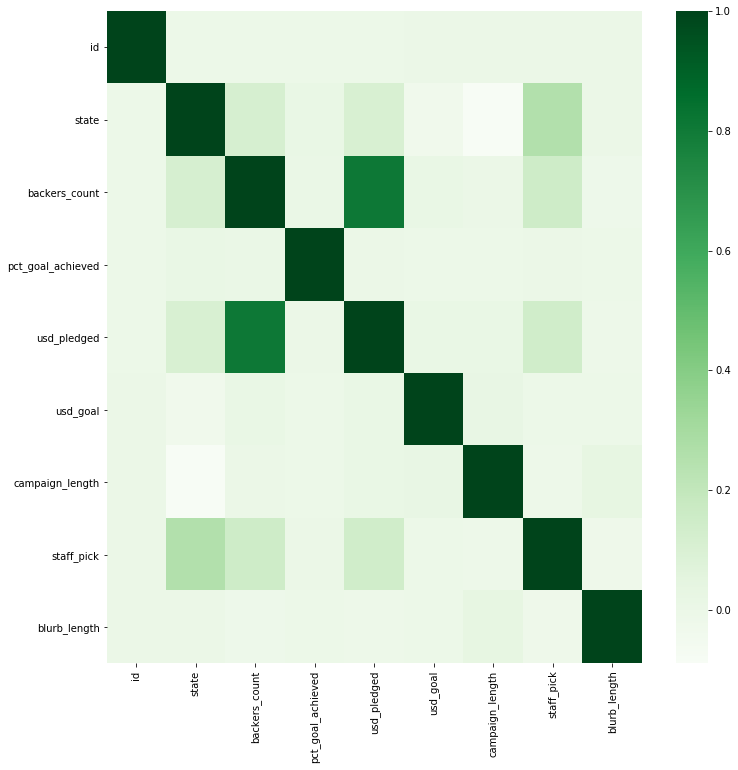

In [7]:
plt.figure(figsize = (12,12))
# sns.heatmap(df.corr(), cmap = 'coolwarm')
sns.heatmap(df.corr(), cmap = "Greens" )
# plot_corr_matrix(df)
# sns.heatmap(df.corr(),linecolor = "coolwarm")

In [8]:
start_date = datetime.datetime.strptime('2016-01-01', "%Y-%m-%d").date()

df = df[df['launched'] >= start_date] # filter from start date to current
df.shape

(41893, 18)

In [9]:
df_success = df[df['state'] == 1]
df_fail = df[df['state'] == 0]
print(df_success.shape)
df_success.head()

(21067, 18)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,deadline,launched,created,staff_pick,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,
2065169465,2065169465,Cotton-Top Pastries,1,food,Small Batch,99,1.3,9858.000000,7500.000000,US,USD,30,2018-01-12,2017-12-13,2017-12-12,1,Holly Weist,5
1647325451,1647325451,Code Switch,1,film_and_video,Horror,34,1.5,4611.000000,3000.000000,US,USD,32,2018-01-12,2017-12-11,2017-11-10,0,Alba Roland,23
1756145145,1756145145,WANGTA: a novel,1,publishing,Fiction,13,1.0,427.185132,427.185132,CA,CAD,21,2018-01-12,2017-12-22,2017-12-18,0,D. H. de Bruin,22
1339075969,1339075969,Run This Place - The Book,1,publishing,Nonfiction,483,1.0,20190.220000,20000.000000,US,USD,30,2018-01-12,2017-12-13,2017-12-12,0,Dane Rauschenberg,18
1928677105,1928677105,Casemates: a wine community site with direct v...,1,technology,Web,1829,2.4,120085.890000,50000.000000,US,USD,15,2018-01-12,2017-12-28,2017-12-18,1,Matt Rutledge,21


In [10]:
print(df_fail.shape)
df_fail.head()

(20826, 18)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,deadline,launched,created,staff_pick,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,
1396766240,1396766240,Ripple Playing Cards - Printed by USPCC,0,games,Playing Cards,131,0.3,3387.0,9999.0,US,USD,38,2018-01-12,2017-12-05,2017-10-08,0,B.Y. Eidelman,16
727157486,727157486,Rain Dog Farm,0,food,Farms,49,0.3,4741.0,18000.0,US,USD,38,2018-01-12,2017-12-05,2017-11-28,1,Charlie Wainger,9
739505843,739505843,Reusable Model Rocket Engines,0,technology,Flight,36,0.5,2401.7,5000.0,US,USD,45,2018-01-12,2017-11-28,2016-12-16,0,XAIR Aerospace Technologies LLC,20
1725323227,1725323227,Inspire young girls,0,fashion,Childrenswear,1,0.0,30.0,1300.0,US,USD,30,2018-01-12,2017-12-13,2017-12-08,0,Rayna,6
220865038,220865038,The New Way to Shop for Babies and Kids,0,fashion,Childrenswear,75,0.1,2734.0,20000.0,US,USD,46,2018-01-12,2017-11-27,2017-10-06,0,Little Starters,25


In [11]:
df.category_main.unique()

array(['games', 'food', 'film_and_video', 'publishing', 'technology',
       'fashion', 'art', 'comics', 'music', 'crafts', 'dance', 'design',
       'photography', 'theater', 'journalism'], dtype=object)

In [12]:
df_success.pct_goal_achieved.mean()
df_fail.pct_goal_achieved.mean()

0.098223145263643716

In [13]:
df.columns

Index(['id', 'name', 'state', 'category_main', 'category_name',
       'backers_count', 'pct_goal_achieved', 'usd_pledged', 'usd_goal',
       'country', 'currency', 'campaign_length', 'deadline', 'launched',
       'created', 'staff_pick', 'creator_name', 'blurb_length'],
      dtype='object')

In [14]:
# df['category_name'].unique()
df.groupby('state').nunique()

,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,deadline,launched,created,staff_pick,creator_name,blurb_length
state,,,,,,,,,,,,,,,,,,
0,20826,20810,1,15,122,315,11,8689,6519,22,14,65,731,724,1250,2,19525,33
1,21067,21057,1,15,140,1663,423,16932,7693,22,14,64,731,727,1249,2,18543,33


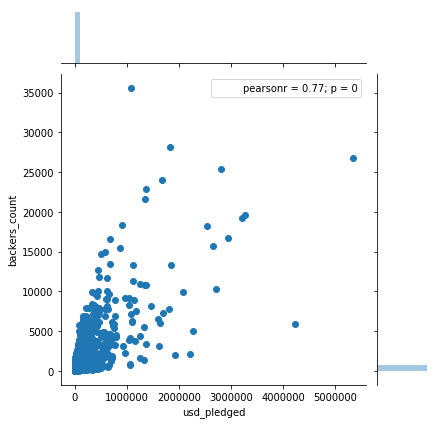

In [15]:
sns.jointplot(x='usd_pledged',y='backers_count', data=df)

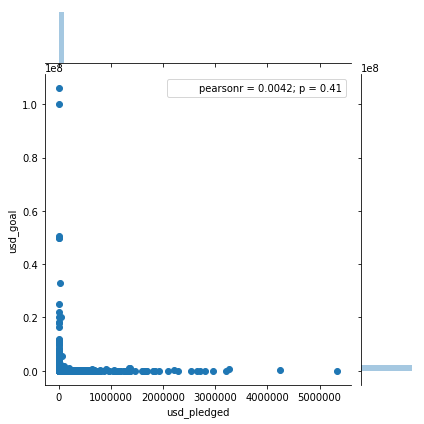

In [16]:
sns.jointplot(x='usd_pledged',y='usd_goal', data=df)

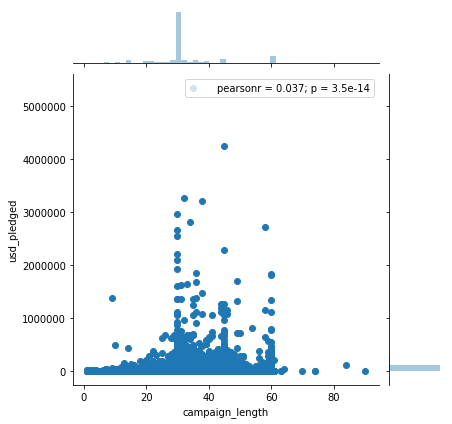

In [17]:
sns.jointplot(x='campaign_length',y='usd_pledged', data=df)

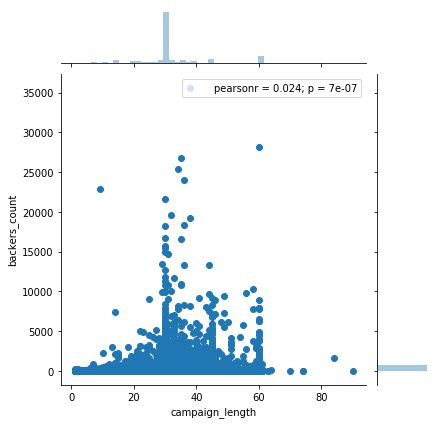

In [18]:
sns.jointplot(x='campaign_length',y='backers_count', data=df)

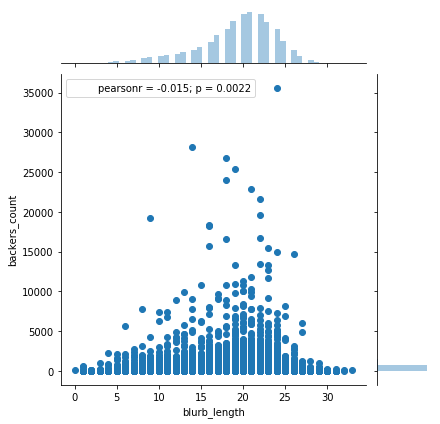

In [19]:
sns.jointplot(x='blurb_length',y='backers_count', data=df)

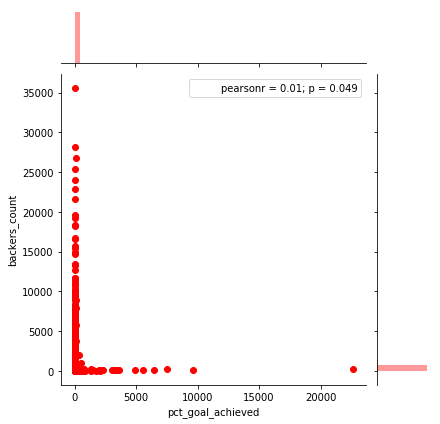

In [20]:
sns.jointplot(x='pct_goal_achieved',y='backers_count',data=df,color='red');

In [21]:
df.columns

Index(['id', 'name', 'state', 'category_main', 'category_name',
       'backers_count', 'pct_goal_achieved', 'usd_pledged', 'usd_goal',
       'country', 'currency', 'campaign_length', 'deadline', 'launched',
       'created', 'staff_pick', 'creator_name', 'blurb_length'],
      dtype='object')

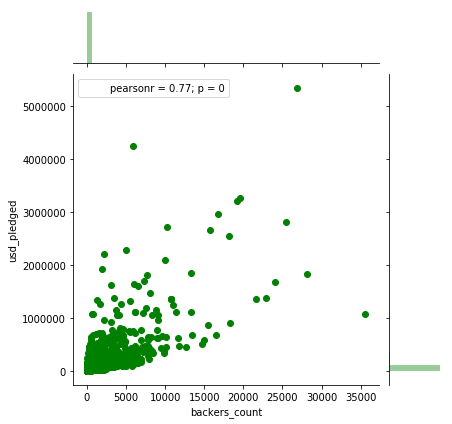

In [22]:
sns.jointplot(x='backers_count',y='usd_pledged',data=df,color='green')

Text(0,0.5,'Frequency')

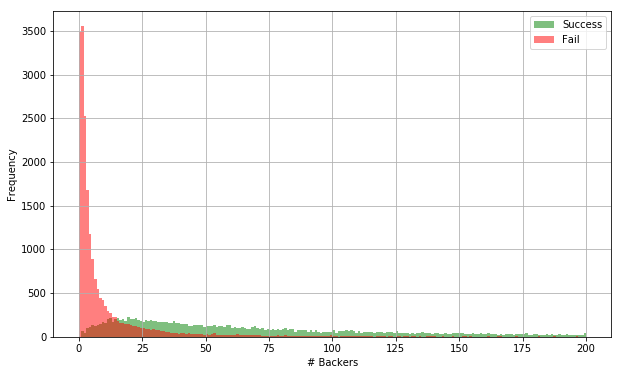

In [23]:
plt.figure(figsize=(10,6))
df[df['state']==1]['backers_count'].hist(range=(0,200), alpha=0.5,color='g',
                                              bins=200,label='Success')
df[df['state']==0]['backers_count'].hist(range=(0,200), alpha=0.5,color='r',
                                              bins=200,label='Fail')
plt.legend()
plt.xlabel('# Backers')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

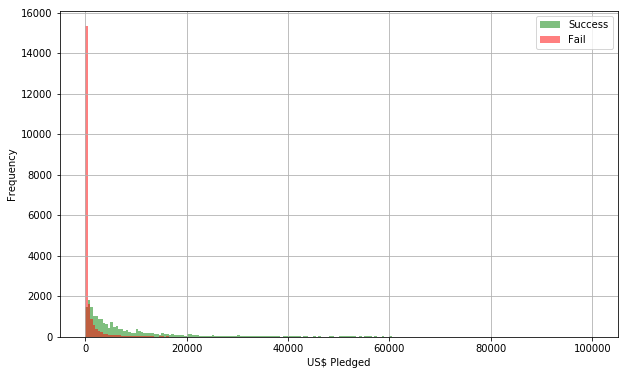

In [24]:
plt.figure(figsize=(10,6))
df[df['state']==1]['usd_pledged'].hist(range=(0,100000), alpha=0.5,color='g',
                                              bins=200,label='Success')
df[df['state']==0]['usd_pledged'].hist(range=(0,100000), alpha=0.5,color='r',
                                              bins=200,label='Fail')
plt.legend()
plt.xlabel('US$ Pledged')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

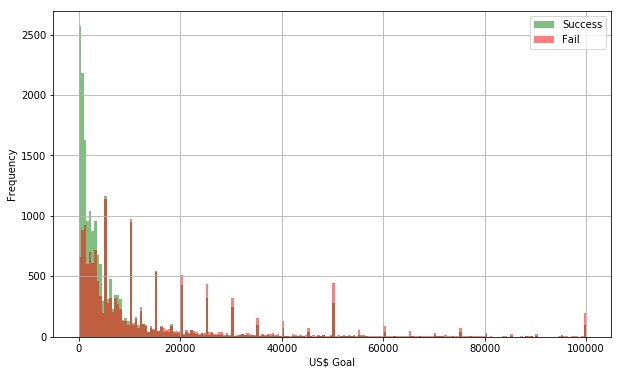

In [25]:
plt.figure(figsize=(10,6))
df[df['state']==1]['usd_goal'].hist(range=(0,100000), alpha=0.5,color='g',
                                              bins=200,label='Success')
df[df['state']==0]['usd_goal'].hist(range=(0,100000), alpha=0.5,color='r',
                                              bins=200,label='Fail')
plt.legend()
plt.xlabel('US$ Goal')
plt.ylabel('Frequency')

In [26]:
# sns.set_style('whitegrid')
# df['pct_goal_achieved'].hist(bins=3000)
# plt.xlabel('pct_goal_achieved')
# # sns.plt.ylim(0,)
# plt.xlim(0,10)

In [27]:
df.staff_pick.sum()

5078

(2, 2)


Text(0,0.5,'Number of Campaigns')

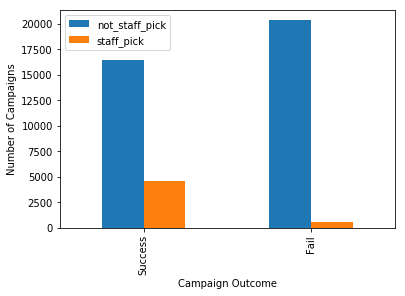

In [28]:
df['not_staff_pick'] = df['staff_pick'].replace({0: 1, 1:0})
df['state'] = df['state'].replace({0: "Fail", 1:"Success"})
# df['total'] = df['staff_pick'] + df['not_staff_pick']
df_staff_pick = df.groupby(["state"]).sum().sort_values(['staff_pick'], ascending=[False])
df_staff_pick = pd.DataFrame(df_staff_pick, columns={'staff_pick','not_staff_pick'})
print(df_staff_pick.shape)
df_staff_pick.plot(kind='bar')
# plt.plot(df_staff_pick, label='stuff')
plt.xlabel('Campaign Outcome')
plt.ylabel('Number of Campaigns')

In [29]:
# ax = sns.barplot(x="state", y='staff_pick', data=df)

# plt.xlabel('state', fontsize=12)
# plt.ylabel('staff_pick', fontsize=12)
# plt.tight_layout()
# # plt.savefig('charts/Top20.png')
# plt.show()

In [30]:
df_state = df.groupby(["state"]).count().sort_values(['name'], ascending=[False])
df_state = pd.DataFrame(df_state, columns={'name'})
print(df_state.shape)
df_state

(2, 1)


,name
state,
Success,21067
Fail,20826


(2, 2)


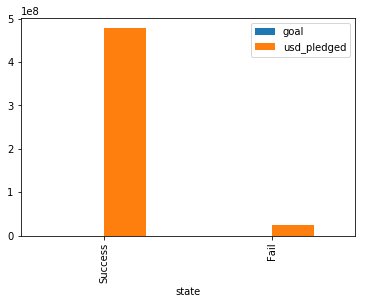

In [31]:
df_state = df.groupby(["state"]).sum().sort_values(['usd_pledged'], ascending=[False])
df_state = pd.DataFrame(df_state, columns={'usd_pledged','goal'})
print(df_state.shape)
df_state.plot(kind='bar')

(2, 1)


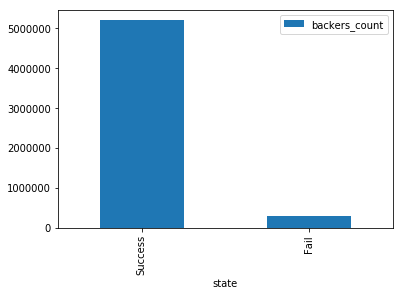

In [32]:
df_state = df.groupby(["state"]).sum().sort_values(['backers_count'], ascending=[False])
df_state = pd.DataFrame(df_state, columns={'backers_count'})
print(df_state.shape)
df_state.plot(kind='bar')

(44, 1)


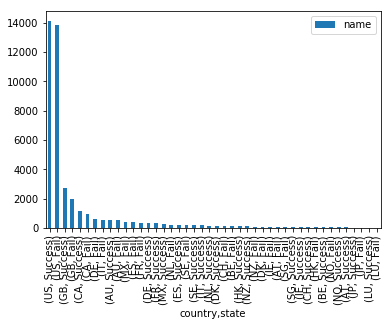

In [33]:
df_country = df.groupby(["country","state"]).count().sort_values(['name'], ascending=[False])
df_country = pd.DataFrame(df_country, columns={'name'})
print(df_country.shape)
df_country.plot(kind='bar')
plt.figsize=(20,10)

(44, 2)


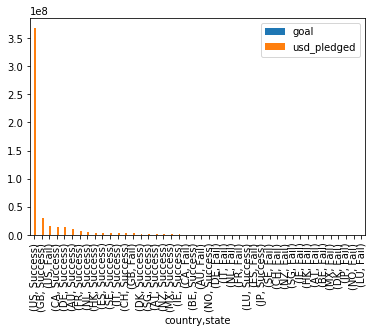

In [34]:
df_country = df.groupby(["country","state"]).sum().sort_values(['usd_pledged'], ascending=[False])
df_country = pd.DataFrame(df_country, columns={'usd_pledged','goal'})
print(df_country.shape)
df_country.plot(kind='bar')

(262, 1)


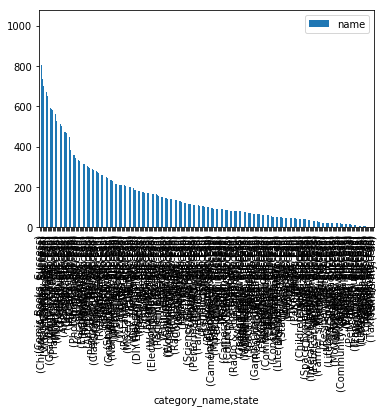

In [35]:
df_main_category = df.groupby(["category_name","state"]).count().sort_values(['name'], ascending=[False])
df_main_category = pd.DataFrame(df_main_category, columns={'name'})
print(df_main_category.shape)
df_main_category.plot(kind='bar')

(262, 2)


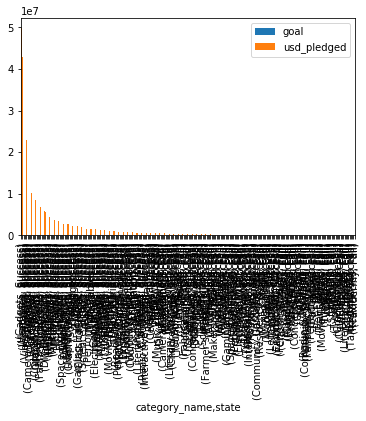

In [36]:
df_main_category = df.groupby(["category_name","state"]).sum().sort_values(['usd_pledged'], ascending=[False])
df_main_category = pd.DataFrame(df_main_category, columns={'usd_pledged', 'goal'})
print(df_main_category.shape)
df_main_category.plot(kind='bar')

In [37]:
# https://github.com/sagarvadher/KickstarterSuccessRatePredicton/blob/master/Kickstarter.ipynb
# from sklearn.base import BaseEstimator
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
# # from graphviz import Source
# from sklearn import tree

In [38]:
# my_decisiontree = DecisionTreeClassifier( random_state = 100,max_depth=2)
# my_decisiontree.fit(X_train, y_train)
# y_predict = my_decisiontree.predict(X_test)
# score = accuracy_score(y_test, y_predict)
# print(score)

In [39]:
# feature_names = list(feature_matrix)
# Source( tree.export_graphviz(my_decisiontree, out_file=None, feature_names=feature_names))

In [40]:
# from sklearn import linear_model
# clf = linear_model.SGDClassifier()
# clf.fit(X_train, y_train)

# y_predict = clf.predict(X_test)
# score = accuracy_score(y_test, y_predict)
# print(score)

In [41]:
# df.columns

Text(0,0.5,'Projects')

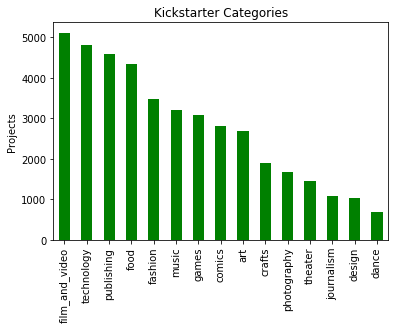

In [42]:
# https://github.com/gagejustins/Kickstarter/blob/master/kickstarter.ipynb
df['category_main'].value_counts().plot(kind='bar', color='g')
plt.title('Kickstarter Categories')
plt.ylabel('Projects')

Text(0,0.5,'Projects')

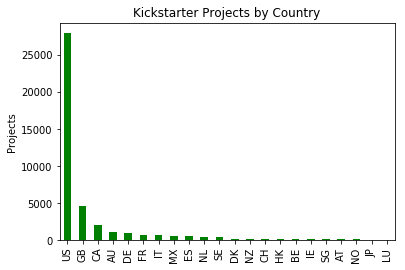

In [43]:
df['country'].value_counts().plot(kind='bar', color='g')
plt.title('Kickstarter Projects by Country')
plt.ylabel('Projects')

Text(0,0.5,'Pledged / Goal Ratio')

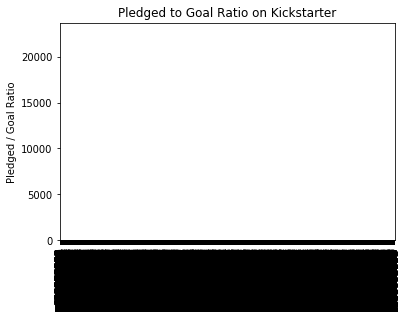

In [44]:
df['pct_goal_achieved'].sort_values(ascending=False).plot(kind='bar', color='g')
plt.title('Pledged to Goal Ratio on Kickstarter')
plt.xlabel('')
plt.ylabel('Pledged / Goal Ratio')

In [45]:
color = ['r', 'g']

df.groupby('category_main').status.value_counts(normalize = True).sort_index().plot(kind = 'bar', color = color, figsize=(20, 6))

AttributeError: 'DataFrameGroupBy' object has no attribute 'status'

In [ ]:
plt.figure(figsize = (6,6))
sns.boxplot(x ='status', y = 'loggoal', data = df)
plt.title('Successful Kickstarters have on average lower Goals')

In [ ]:
df.category_main.value_counts(normalize = True).plot(kind = 'pie', figsize=(9, 6))

In [ ]:
# https://github.com/gagejustins/Kickstarter/blob/master/kickstarter.ipynb
#Projects over time
kickTime = kick.copy()
kickTime.set_index('launched', inplace=True)
grouped = kickTime.resample("A").agg({'ID': np.size})
grouped.index = grouped.index.year
grouped.iloc[len(grouped)-8:len(grouped)].plot(kind='bar', color='#2ADC75', legend=None)
plt.title('Projects Launched')
plt.xlabel('')

In [ ]:
# Resources
# https://github.com/soniakt23/KickstarterFundingPredictor/blob/master/Data%20Analysis.ipynb
# https://github.com/nalamidi/Kickstarter-Predictive-Analysis/blob/master/Kickstarter/Kick-Starter%20Project-Analysis.ipynb